In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
import sys
from __future__ import division
sys.path.append(r"C:\dev\opinion\opinion\python\opinion")
import os
import utils.fileutils as fileutils
import utils.nlputils as nlputils
import cPickle as pickle
import pandas as pd
import numpy as np
import utils.metrics as metrics

from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
stopWords = set(stopwords.words('english'))

import statsmodels.api as sm
import statsmodels.formula.api as smf

import scipy as sp
import spacy
from random import sample

import gensim
from gensim import corpora

from scipy.stats import kurtosis
from scipy.stats import skew
from scipy.stats import mannwhitneyu
from math import sqrt
import matplotlib.pyplot as plt

import datetime

from statistics import mean, stdev
from math import sqrt
import matplotlib.pyplot as plt

C:\anaconda3\envs\opinion2\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
def readPKL(infile):
    with open(infile, 'rb') as f:
        data = pickle.load(f)
    return data

In [3]:
indir = r"C:\dev\opinion\papers\covid19\CovidDevRantOpenCoding"
infile = os.path.join(indir, "CovidTagContentsWithCategory.xlsx")
indirCovidTags = os.path.join(indir, "allTags")

# check the distribution of the posts over time

In [4]:
df = pd.read_excel(infile)
df.head()

,id,creation_time,score,num_comments,tags,has_image,text,Relevant,Label1,Label2,...,polarity,Emotion1,Emotion2,Emotion3,sarcasm,irony,Category1,Category2,Category3,Category4
0,2438510,2020-03-21 15:17:25,106,17,rant,NaN,Clickbait will never change. \nIt's the most s...,N,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2423716,2020-03-05 07:31:51,95,10,"joke/meme,covid-19,corona,bug,ticket",NaN,COVID-19\nWhy it sounds like a JIRA ticket?,Y,joke/meme,bug,...,n,Anger,NaN,NaN,Y,NaN,NaN,"joke/meme,coding & maintenance","entertainment,development","Wellbeing,Technical"
2,2452432,2020-04-05 18:52:13,66,7,"devrant,corona virus",NaN,"*Corona Virus Lock-down*\n-University Prof: ""N...",Y,lockdown,work life balance,...,n,Anger,NaN,NaN,Y,NaN,NaN,"quarantine,Freetime/Vacation","pandemic,work/life work/life balance","Emergency ,Wellbeing"
3,2433818,2020-03-17 01:35:43,60,15,random,NaN,My fucking company just decided that anyone wh...,Y,paycut,telework,...,n,Surprise,Fear,Anger,N,NaN,NaN,legal iusse,"job,telework,politics","Financial,workplace,Societal"
4,2388796,2020-02-01 14:10:23,50,5,"joke/meme,windows,virus,corona,linux,.exe",{u'url': u'https://img.devrant.com/devrant/ran...,jUsT uSe LiNuX,Y,joke/meme,linux,...,o,Love,NaN,NaN,Y,NaN,OS,"joke/meme,software","entertainment,technology","Wellbeing,Technical"


In [5]:
df.Relevant.unique()

array([u'N', u'Y', nan], dtype=object)

In [6]:
def computeCountByMonth():
    counts = dict()
    tot = 0
    #isrelevant = pd.isnull(df["Relevant"])
    for index, row in df.iterrows():
        isrelevant = row["Relevant"]
        if isrelevant != 'Y': continue
        ctime = row['creation_time']
        #ctime = ctime.split()[0]
        #print ctime
        #print dp.strftime("%Y-%m-%d")
        #dp = datetime.datetime.fromtimestamp(ctime)
        #print dp.strftime("%Y-%m-%d")
        dp = ctime
        if dp.year < 2020 : continue
        if dp.year == 2020 and dp.month >4 : continue
        dd = dp.strftime("%Y-%m-%d")
        dd = dp.isocalendar()[1]
        #print dd
        dd = dp.month
        #print dd
        if dd not in counts: counts[dd] = 0
        counts[dd] += 1 #+ rec["num_comments"]
        tot += 1
    print tot
    return counts

def computeCountByDate():
    recs = []
    counts = dict()
    tot = 0
    for index, row in df.iterrows():
        isrelevant = row["Relevant"]
        if isrelevant == 'N': continue
        ctime = row['creation_time']
        #ctime = ctime.split()[0]
        #print ctime
        #print dp.strftime("%Y-%m-%d")
        #dp = datetime.datetime.fromtimestamp(ctime)
        #print dp.strftime("%Y-%m-%d")
        dp = ctime
        if dp.year < 2020 : continue
        if dp.year == 2020 and dp.month >4 : continue
        dd = dp.strftime("%Y-%m-%d")
        #dd = dp.isocalendar()[1]
        #print dd
        #dd = dp.month
        #print dd
        if dd not in counts: counts[dd] = 0
        counts[dd] += 1 #+ rec["num_comments"]
        tot += 1
    print tot
    for dd, val in counts.items():
        recs.append({"Date":dd, "Total":val})
    pdf = pd.DataFrame.from_dict(recs)
    return pdf

def computeAllCountByDate():
    recs = []
    counts = dict()
    tot = 0
    for index, row in df.iterrows():
        #isrelevant = row["Relevant"]
        #if isrelevant != 'Y': continue
        ctime = row['creation_time']
        #ctime = ctime.split()[0]
        #print ctime
        #print dp.strftime("%Y-%m-%d")
        #dp = datetime.datetime.fromtimestamp(ctime)
        #print dp.strftime("%Y-%m-%d")
        dp = ctime
        if dp.year < 2020 : continue
        if dp.year == 2020 and dp.month >4 : continue
        dd = dp.strftime("%Y-%m-%d")
        #dd = dp.isocalendar()[1]
        #print dd
        #dd = dp.month
        #print dd
        if dd not in counts: counts[dd] = 0
        counts[dd] += 1 #+ rec["num_comments"]
        tot += 1
    print tot
    for dd, val in counts.items():
        recs.append({"Date":dd, "Total":val})
    pdf = pd.DataFrame.from_dict(recs)
    return pdf


825


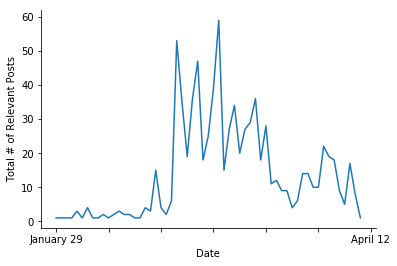

In [7]:
pdf = computeCountByDate()
dd = pdf.sort_values('Date', axis=0,ascending=True) 
#for index, row in dd.iterrows():
#    print row['Date'], row['Total']

import matplotlib.ticker as ticker
ax = dd.plot(x="Date")
xticks = ax.xaxis.get_major_ticks()
ax.axes.xaxis.set_ticklabels([0, "January 29", "", "", "", "","", "April 12"], rotation="horizontal")
#ax.axes.yaxis.set_ticklabels([])
#plt.xticks([to_integer(datetime.date(df.date.min())), to_integer(datetime.date(df.date.max()))], visible=True, rotation="horizontal")
#my_xticks = ax.get_xticks()
#print my_xticks
ax.get_legend().remove()
ax.set_ylabel("Total # of Relevant Posts")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#plt.xticks(df.date, rotation="vertical")
outfile = os.path.join(indir, "RelevantPostsByDate.pdf")
plt.savefig(outfile)

919


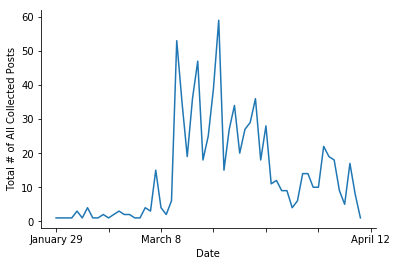

In [9]:
pdfAll = computeAllCountByDate()
dd = pdf.sort_values('Date', axis=0,ascending=True) 
#for index, row in dd.iterrows():
#    print row['Date'], row['Total']

import matplotlib.ticker as ticker
ax = dd.plot(x="Date")
xticks = ax.xaxis.get_major_ticks()
ax.axes.xaxis.set_ticklabels([0, "January 29", "", "March 8", "", "","", "April 12"], rotation="horizontal")
#ax.axes.yaxis.set_ticklabels([])
#plt.xticks([to_integer(datetime.date(df.date.min())), to_integer(datetime.date(df.date.max()))], visible=True, rotation="horizontal")
#my_xticks = ax.get_xticks()
#print my_xticks
ax.get_legend().remove()
ax.set_ylabel("Total # of All Collected Posts")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#plt.xticks(df.date, rotation="vertical")
outfile = os.path.join(indir, "AllPostsByDate.pdf")
plt.savefig(outfile)

# compute tag vs post distribution

In [10]:
def computeScoreStat(isRelevant=False):
    scores = []
    #df = pd.read_excel(infile)
    for index, row in df.iterrows():
        relevant = row["Relevant"]
        if isRelevant:
            if relevant != 'Y': continue
        score = row["score"]
        scores.append(score)
    scores = np.array(scores)
    print "avg = ", np.average(scores)
    print "min = ", np.min(scores)
    print "max = ", np.max(scores)
    print "std = ", np.std(scores)

In [11]:
computeScoreStat(True)

avg =  13.174882629107982
min =  0
max =  203
std =  17.409286769747187


# compute tag association

In [12]:
baseTags = ['covid', 'covid-19', 'covid19', 'corona', 'corona virus', 'coronavirus', 
            'pandemic', 'quarantine', 'lockdown', '2019-ncov', 'pig flu']
derivedTags = ['working from home', 'wfh', 'isolation', 'telework', 'video conferencing', 
              'apocalypse', 'bat attack', 'virus', 
              'covid-19 global hackathon', 'jaicorona', 'joke/meme', 'rant', 'wk199', 'wk200', 'wk201', 'wk202', 'wk203']

In [13]:
def findAssociatedTags():
    rTags = dict()
    aTags = dict()
    for index, row in df.iterrows():
        tag =  row["tags"]
        tag = tag.lower()
        tags = tag.split(",")
        associate = False
        for tag in tags:
            
            tag = tag.strip()
            if tag not in aTags: aTags[tag] = 0
            aTags[tag] += 1
            if tag in baseTags: 
                associate = True
                #break
        if associate == True:
            for tag in tags:
                if tag not in baseTags:
                    if tag not in rTags: rTags[tag] = 0
                    rTags[tag] += 1
    return rTags, aTags

In [14]:
rTags, aTags = findAssociatedTags()
rTags

{u'.exe': 3,
 u'19': 3,
 u'2016': 1,
 u'2020': 2,
 u'2fa': 3,
 u'5g': 1,
 u'@whocares': 2,
 u'absurdity': 2,
 u'advertising': 2,
 u'ago': 2,
 u'airlines': 5,
 u'alcoholic': 3,
 u'android': 4,
 u'antisocial distancing': 2,
 u'antivirus': 2,
 u'ap': 3,
 u'api': 2,
 u'apocalypse': 8,
 u'april fools': 1,
 u"aussies don't do isolation well": 3,
 u'austria': 1,
 u'aws': 4,
 u'bandanna': 2,
 u'bat attack': 5,
 u'bill gates': 2,
 u'birthday': 1,
 u'boored': 1,
 u'boredom': 1,
 u'budget': 3,
 u'bug': 3,
 u'c0d4 keeping warm tonight': 3,
 u'cake': 1,
 u'calculations for research': 3,
 u'centos': 3,
 u'chatroulette': 5,
 u'china': 4,
 u'chink': 1,
 u'chong': 1,
 u'cloud websites': 1,
 u'cobol': 2,
 u'conspiracy': 3,
 u'consulting': 4,
 u'corona antivirus': 4,
 u'coronas for everyone': 4,
 u'coronovirus': 1,
 u'cors': 3,
 u'cov19': 1,
 u'covid-19 global hackathon': 4,
 u'cpu power': 3,
 u'crap': 3,
 u'crazy world': 1,
 u'crisis': 1,
 u'currency': 3,
 u'custom': 3,
 u'custom router': 3,
 u'darkmode

In [15]:
len(rTags)

266

In [16]:
count = 0
for tag in derivedTags:
    if tag in rTags:
        count += 1
    else:
        print tag
print count

wk202
wk203
15


In [17]:
len(aTags)

808

In [18]:
for tag in baseTags:
    if tag not in aTags:
        print tag

In [20]:
for tag in aTags:
    if 'distancing' in tag: print tag

covid-19 social-distancing idiots
antisocial distancing
social distancing


In [21]:
len(baseTags), len(derivedTags)

(11, 17)

In [22]:
allTags = baseTags + derivedTags
allTags

['covid',
 'covid-19',
 'covid19',
 'corona',
 'corona virus',
 'coronavirus',
 'pandemic',
 'quarantine',
 'lockdown',
 '2019-ncov',
 'pig flu',
 'working from home',
 'wfh',
 'isolation',
 'telework',
 'video conferencing',
 'apocalypse',
 'bat attack',
 'virus',
 'covid-19 global hackathon',
 'jaicorona',
 'joke/meme',
 'rant',
 'wk199',
 'wk200',
 'wk201',
 'wk202',
 'wk203']

In [23]:
# see if all posts are covered by base and derived tags
allCTags = ['#'+t for t in allTags]
sTags = allTags + allCTags
sTags = set(sTags)
for index, row in df.iterrows():
    relevant = row["Relevant"]
    if relevant != 'Y': continue
    tag =  row["tags"]
    tag = tag.lower()
    tags = tag.split(",")
    associate = False
    cTags = set()
    for tag in tags:
        tag = tag.strip()
        cTags.add(tag)
    common = sTags.intersection(cTags)
    if len(common) == 0:
        print index, row["id"], row['creation_time'], tags#, row['text']
        print "=========================================="

3 2433818 2020-03-17 01:35:43 [u'random']
8 2439836 2020-03-23 12:04:42 [u'devrant', u'programmers', u'jokes', u'programming', u'memes', u'startups', u'office']
35 2429464 2020-03-12 03:11:08 [u'random', u'corona bs', u'work', u'every day']
39 2430063 2020-03-12 16:05:25 [u'random', u'zombies', u'end of the world', u'huricane']
62 2448996 2020-04-02 06:21:23 [u'devrant', u'windows', u'technical problems', u'git', u'home office']
66 2411243 2020-02-23 18:04:46 [u'random']
67 2438651 2020-03-21 19:05:30 [u'question', u'#covid #corona #mentalhealth']
74 2419480 2020-03-02 11:23:19 [u'random', u'google io 2020', u'google io']
82 2432462 2020-03-15 14:40:30 [u'random', u'hangry', u'joke']
85 2440927 2020-03-24 15:47:16 [u'question']
88 275696 2016-11-07 12:33:38 [u'undefined']
89 2433531 2020-03-16 17:07:49 [u'random', u'kong flu']
104 2441810 2020-03-25 17:26:14 [u'devrant']
147 2386920 2020-01-30 23:17:26 [u'random', u'telegram bot', u'bot', u'telegram']
157 2430063 2020-03-12 16:05:25 [u

In [24]:
# check number of comments in the relevant posts
tot_com = 0
coms = []
for index, row in df.iterrows():
    num_com = row["num_comments"]
    isrelevant = row["Relevant"]
    if isrelevant != 'Y': continue
    tot_com += num_com
    coms.append(num_com)
print tot_com
coms = np.array(coms)
print np.average(coms), np.max(coms), np.min(coms), np.std(coms)

5384
6.31924882629108 53 0 6.714776320323872


# check distinct users created the posts

In [25]:

sTags

{'#2019-ncov',
 '#apocalypse',
 '#bat attack',
 '#corona',
 '#corona virus',
 '#coronavirus',
 '#covid',
 '#covid-19',
 '#covid-19 global hackathon',
 '#covid19',
 '#isolation',
 '#jaicorona',
 '#joke/meme',
 '#lockdown',
 '#pandemic',
 '#pig flu',
 '#quarantine',
 '#rant',
 '#telework',
 '#video conferencing',
 '#virus',
 '#wfh',
 '#wk199',
 '#wk200',
 '#wk201',
 '#wk202',
 '#wk203',
 '#working from home',
 '2019-ncov',
 'apocalypse',
 'bat attack',
 'corona',
 'corona virus',
 'coronavirus',
 'covid',
 'covid-19',
 'covid-19 global hackathon',
 'covid19',
 'isolation',
 'jaicorona',
 'joke/meme',
 'lockdown',
 'pandemic',
 'pig flu',
 'quarantine',
 'rant',
 'telework',
 'video conferencing',
 'virus',
 'wfh',
 'wk199',
 'wk200',
 'wk201',
 'wk202',
 'wk203',
 'working from home'}

In [30]:
tags = fileutils.get_filelist_nopath_noextension(indirCovidTags)
overallRants = set()
overallNumComments = 0
overallScores = []
overallUsers = set()
lTags = list(sTags)
overallReputations = []
for i, tag in enumerate(lTags):
    #print tag
    infile = os.path.join(indirCovidTags, tag+".pkl")
    if os.path.exists(infile) == False: continue
    data = readPKL(infile)
    recs = data['results']
    numRants = 0
    numComments = 0
    scores = []
    users = set()
    reps = []
    for rec in recs:
        iid = rec['id']
        
        ctime = rec['created_time']
        dp = datetime.datetime.fromtimestamp(ctime)
        if dp.year < 2020: continue
        numRants += 1
        numComments += rec['num_comments']
        
        scores.append(rec['score'])
        users.add(rec['user_id'])
        reps.append(rec['user_score'])
        
        if iid not in overallRants:
            overallNumComments += rec['num_comments']
            overallUsers.add(rec['user_id'])
            overallScores.append(rec['score'])
            overallReputations.append(rec['user_score'])
        
        overallRants.add(iid)
    scores = np.array(scores)
    reps = np.array(reps)
    print i, "Tag = %s. Num Rants = %d. Num Comments = %d. Scores = %.1f. Users = %d. Reputations = %.1f"%(tag, 
                                                                                                        numRants, 
                                                                                                        numComments, 
                                                                        np.mean(scores),
                                                                       len(users), np.mean(reps))
overallScores = np.array(overallScores)
overallReputations = np.array(overallReputations)
print  "Tag = %s. Num Rants = %d. Num Comments = %d. Scores = %.1f. Users = %d. Reputations = %.1f"%("Overall", 
                                                                                                        len(overallRants), 
                                                                                                        overallNumComments, 
                                                                                                        np.mean(overallScores),
                                                                                                        len(overallUsers), 
                                                                                                        np.mean(overallReputations))
    

0 Tag = corona virus. Num Rants = 28. Num Comments = 150. Scores = 14.5. Users = 28. Reputations = 5079.9
1 Tag = pig flu. Num Rants = 1. Num Comments = 21. Scores = 14.0. Users = 1. Reputations = 5166.0
3 Tag = #rant. Num Rants = 0. Num Comments = 0. Scores = nan. Users = 0. Reputations = nan
5 Tag = bat attack. Num Rants = 1. Num Comments = 14. Scores = 14.0. Users = 1. Reputations = 6857.0
7 Tag = covid-19. Num Rants = 85. Num Comments = 639. Scores = 10.4. Users = 67. Reputations = 6240.1
9 Tag = wk199. Num Rants = 109. Num Comments = 458. Scores = 11.4. Users = 97. Reputations = 5209.9
10 Tag = wk201. Num Rants = 39. Num Comments = 156. Scores = 8.5. Users = 37. Reputations = 6521.4
11 Tag = wk200. Num Rants = 87. Num Comments = 264. Scores = 11.6. Users = 78. Reputations = 5983.2
12 Tag = wk203. Num Rants = 15. Num Comments = 96. Scores = 29.1. Users = 13. Reputations = 5050.5
13 Tag = wk202. Num Rants = 79. Num Comments = 226. Scores = 11.9. Users = 72. Reputations = 5354.7
17 T